Выполнил: Бешляга Григорий Константинович

Мультивариативный ряд: временные ряды метеорологических данных.<br>
Решаем задачу регресии. Предсказываем такие характеристики, как: температуру в градусах Цельсия, точку росы в градусах Цельсия, относительную влажность в процентах, скорость ветра в километрах в час, видимость в километрах, атмосферное давление в килопаскалях.
Замеры данных проводятся каждый час, период: 2012 год.

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima import auto_arima
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from keras import Input, Model
from sklearn.model_selection import GridSearchCV
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
my_seed = 52
torch.manual_seed(my_seed)
torch.cuda.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

file_path = '/content/Weather Data (1).csv'
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date/Time'], format='%m/%d/%Y %H:%M')
selected_columns = ['Date', "Temp_C", "Dew Point Temp_C", "Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"]
data = data[selected_columns]

# Блок предобработки временного ряда
## Свойства временных рядов

Просмотр основной информации о мультивариационном ряде

In [ ]:
data

Date  Temp_C  Dew Point Temp_C  Rel Hum_%  \
0    2012-01-01 00:00:00    -1.8              -3.9         86   
1    2012-01-01 01:00:00    -1.8              -3.7         87   
2    2012-01-01 02:00:00    -1.8              -3.4         89   
3    2012-01-01 03:00:00    -1.5              -3.2         88   
4    2012-01-01 04:00:00    -1.5              -3.3         88   
...                  ...     ...               ...        ...   
8779 2012-12-31 19:00:00     0.1              -2.7         81   
8780 2012-12-31 20:00:00     0.2              -2.4         83   
8781 2012-12-31 21:00:00    -0.5              -1.5         93   
8782 2012-12-31 22:00:00    -0.2              -1.8         89   
8783 2012-12-31 23:00:00     0.0              -2.1         86   

      Wind Speed_km/h  Visibility_km  Press_kPa  
0                   4            8.0     101.24  
1                   4            8.0     101.24  
2                   7            4.0     101.26  
3                   6            4.0     101.27  
4                   7            4.8     101.23  
...               ...            ...        ...  
8779               30            9.7     100.13  
8780               24            9.7     100.03  
8781               28            4.8      99.95  
8782               28            9.7      99.91  
8783               30           11.3      99.89  

[8784 rows x 7 columns]

In [ ]:
data.describe()

Temp_C  Dew Point Temp_C    Rel Hum_%  Wind Speed_km/h  \
count  8784.000000       8784.000000  8784.000000      8784.000000   
mean      8.798144          2.555294    67.431694        14.945469   
std      11.687883         10.883072    16.918881         8.688696   
min     -23.300000        -28.500000    18.000000         0.000000   
25%       0.100000         -5.900000    56.000000         9.000000   
50%       9.300000          3.300000    68.000000        13.000000   
75%      18.800000         11.800000    81.000000        20.000000   
max      33.000000         24.400000   100.000000        83.000000   

       Visibility_km    Press_kPa  
count    8784.000000  8784.000000  
mean       27.664447   101.051623  
std        12.622688     0.844005  
min         0.200000    97.520000  
25%        24.100000   100.560000  
50%        25.000000   101.070000  
75%        25.000000   101.590000  
max        48.300000   103.650000

Графики временных рядов

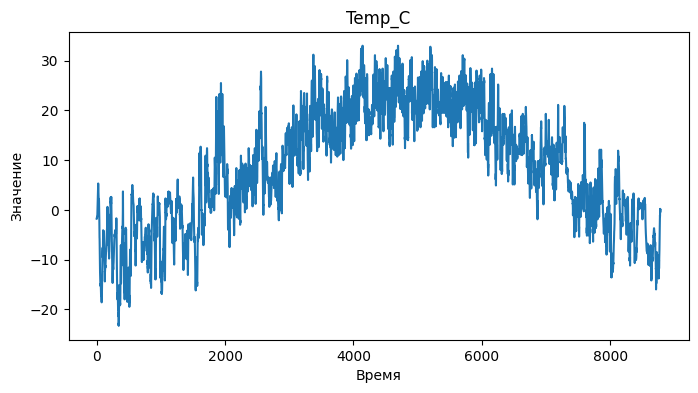

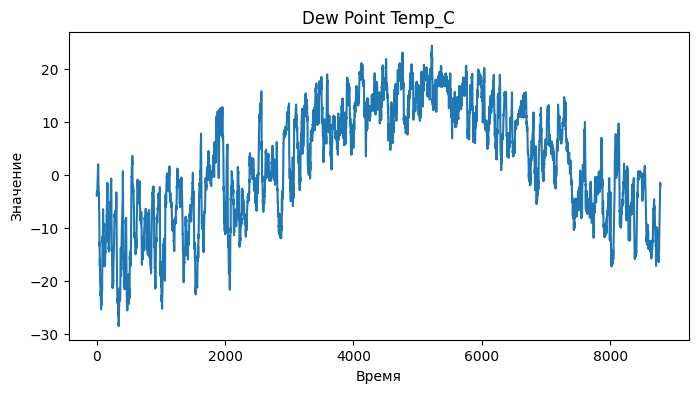

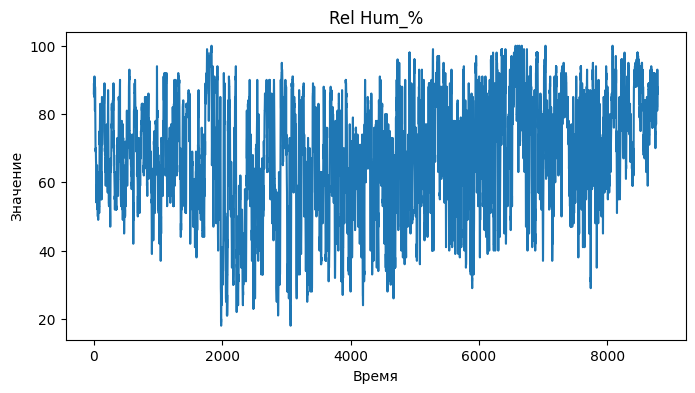

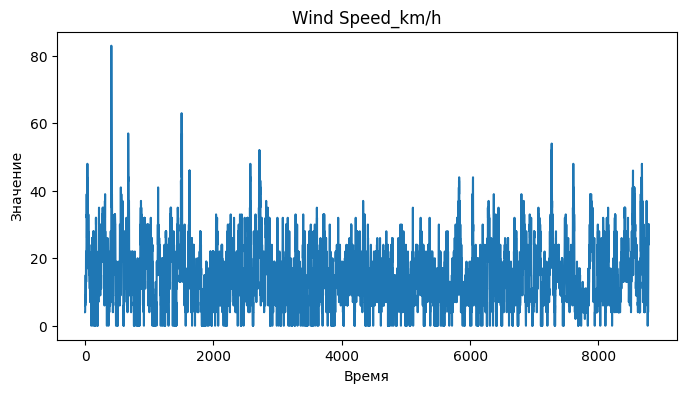

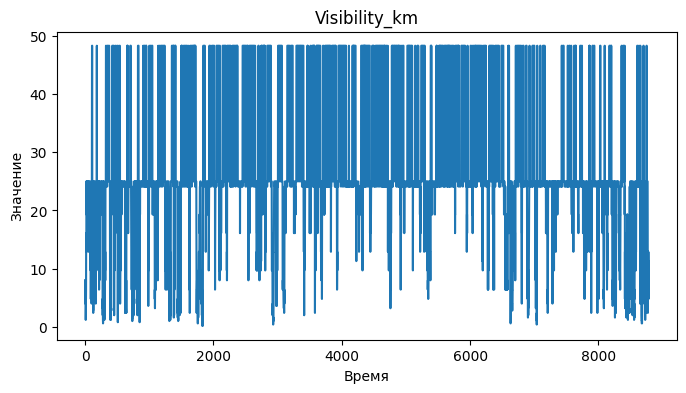

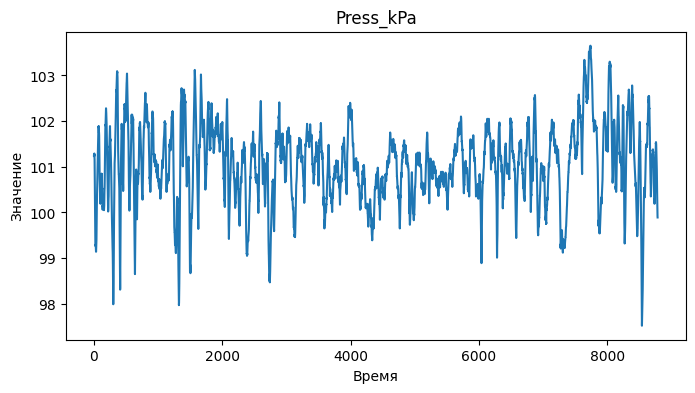

In [ ]:
columns = data.columns

for column in columns:
    if column != 'Date':
        plt.figure(figsize=(8, 4))
        plt.plot(data[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

Проверка на то, что все данные передаются через равный промежуток времени. Данные в датасете передаются через 10 минут.

In [ ]:
time_diff = data['Date'].diff()
time_diff.unique()

array([        'NaT', 3600000000000], dtype='timedelta64[ns]')

Просмотр пропущенных значений во временном ряде

In [ ]:
missing_values = data.isnull().sum()
missing_values

Date                0
Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
dtype: int64

### Проверка рядов на стационарность

In [ ]:
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [ ]:
for col in data.columns:
    if col != 'Date':
        df_test(col, data[col])

Тест Дики-Фуллера ряда Temp_C:
Test Statistic                   -3.252861
p-value                           0.017122
#Lags Users                      37.000000
Number of Observations Used    8746.000000
Critical Value (1%)              -3.431098
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Dew Point Temp_C:
Test Statistic                   -4.760585
p-value                           0.000065
#Lags Users                      32.000000
Number of Observations Used    8751.000000
Critical Value (1%)              -3.431097
Critical Value (5%)              -2.861870
Critical Value (10%)             -2.566946
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Rel Hum_%:
Test Statistic                -1.155091e+01
p-value                        3.449423e-21
#Lags Users                    2.600000e+01
Number of Observations Used    8.757000e+03
Cr

Для прогнозирования в моделях VAR, VARMA важна стационарность.<br>
Для нейронок это уже необязательно.

### Коинтеграция

Коинтеграция временных рядов – это существование стационарной линейной комбинации двух рядов. Чем сильнее коинтеграция, тем лучше сработают векторные модели для мультивариативных временных рядов.

Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.).

In [ ]:
del data['Date']

pairs = combinations(data.columns, 2)

for pair in pairs:
    pair_data = data[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между Temp_C и Dew Point Temp_C
Есть коинтеграция между Temp_C и Rel Hum_%
Есть коинтеграция между Temp_C и Wind Speed_km/h
Есть коинтеграция между Temp_C и Visibility_km
Отсутствует коинтеграция между Temp_C и Press_kPa
Есть коинтеграция между Dew Point Temp_C и Rel Hum_%
Есть коинтеграция между Dew Point Temp_C и Wind Speed_km/h
Есть коинтеграция между Dew Point Temp_C и Visibility_km
Есть коинтеграция между Dew Point Temp_C и Press_kPa
Есть коинтеграция между Rel Hum_% и Wind Speed_km/h
Есть коинтеграция между Rel Hum_% и Visibility_km
Есть коинтеграция между Rel Hum_% и Press_kPa
Есть коинтеграция между Wind Speed_km/h и Visibility_km
Есть коинтеграция между Wind Speed_km/h и Press_kPa
Есть коинтеграция между Visibility_km и Press_kPa


### Причинность рядов по Грейнджеру

In [ ]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns):
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
warnings.filterwarnings("ignore")
j_test = grangers_causation_matrix(data, variables = data.columns)
warnings.filterwarnings("default")
j_test

100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


Temp_C_x  Dew Point Temp_C_x  Rel Hum_%_x  \
Temp_C_y                 1.0              0.0000          0.0   
Dew Point Temp_C_y       0.0              1.0000          0.0   
Rel Hum_%_y              0.0              0.0000          1.0   
Wind Speed_km/h_y        0.0              0.0000          0.0   
Visibility_km_y          0.0              0.0001          0.0   
Press_kPa_y              0.0              0.0000          0.0   

                    Wind Speed_km/h_x  Visibility_km_x  Press_kPa_x  
Temp_C_y                       0.0000              0.0          0.0  
Dew Point Temp_C_y             0.0000              0.0          0.0  
Rel Hum_%_y                    0.0000              0.0          0.0  
Wind Speed_km/h_y              1.0000              0.0          0.0  
Visibility_km_y                0.0000              1.0          0.0  
Press_kPa_y                    0.0041              0.0          1.0

Если результат теста Грейнджера показывает строгое значение p-уровня значимости равное нулю или близкое к нулю (< 0.05) для пары временных рядов, это обычно интерпретируется как сильное статистическое доказательство в пользу наличия причинной связи между этими рядами. Ну и как итог - VAR модели подходят идеально.

## Прогнозирование временного ряда

#### VAR

VAR (Vector AutoRegression) - это тип статистической модели временных рядов, используемой для прогнозирования изменений в нескольких взаимосвязанных переменных с течением времени. Это многомерное расширение модели авторегрессии (AR).

VAR моделирует каждую переменную как линейную комбинацию ее предыдущих значений и предыдущих значений других переменных. Таким образом, все переменные в системе рассматриваются как эндогенные, и модель позволяет нам улучшить прогнозы путем учета взаимосвязей между переменными.

Для начала - подберем наилучший порядок, исходя из информационных критериев:<br>

AIC (Akaike Information Criterion)<br>
BIC (Bayesian Information Criterion)<br>
FPE (Final Prediction Error)<br>
HQC (Hannan-Quinn Criterion).<br>

Меньшие значения критериев указывают на лучшую модель, и их можно использовать для выбора оптимального порядка модели VAR.

In [ ]:
train, test = data[:7000], data[7000:]

model = VAR(train)

orders = [2,6,12,20,24,30,40,48,50,96,168,252,336]
AIC_min = 1
BIC_min = 1
FPE_min = 1
HQC_min = 1

results = [[],[],[],[]]
for i in orders:
    result = model.fit(i)
    results[0].append(result.aic)
    results[1].append(result.bic)
    results[2].append(result.fpe)
    results[3].append(result.hqic)

best_pos = [np.argmin(results[0]),np.argmin(results[1]),np.argmin(results[2]),np.argmin(results[3])]

for i,j in enumerate(zip(*results)):
    print('Lag Order =', orders[i])
    print('AIC : ', j[0], "*" if i == best_pos[0] else "")
    print('BIC : ', j[1], "*" if i == best_pos[1] else "")
    print('FPE : ', j[2], "*" if i == best_pos[2] else "")
    print('HQIC: ', j[3], "*" if i == best_pos[3] else "", '\n')

Lag Order = 2
AIC :  0.1312149811664645 
BIC :  0.20760303696645813 
FPE :  1.140212908498626 
HQIC:  0.1575374570353565  

Lag Order = 6
AIC :  -0.1144602453198936 
BIC :  0.10305810722691472 *
FPE :  0.8918479210064105 
HQIC:  -0.039503682371491905 * 

Lag Order = 12
AIC :  -0.17725121378081177 
BIC :  0.2522213042514191 
FPE :  0.8375731687484449 
HQIC:  -0.02924911629140775  

Lag Order = 20
AIC :  -0.228896351309512 
BIC :  0.483665804294952 
FPE :  0.795427550237515 
HQIC:  0.01667644054266304  

Lag Order = 24
AIC :  -0.26387309911654844 
BIC :  0.590441829218066 
FPE :  0.7680985996459204 
HQIC:  0.030560930167502498  

Lag Order = 30
AIC :  -0.29512047848762085 *
BIC :  0.7720841652824599 
FPE :  0.744494062629883 *
HQIC:  0.072700500304414  

Lag Order = 40
AIC :  -0.2636377030479341 
BIC :  1.1590797758763418 
FPE :  0.768379508299879 
HQIC:  0.22674912627970978  

Lag Order = 48
AIC :  -0.24366268481981895 
BIC :  1.4640940200828023 
FPE :  0.7839774452369933 
HQIC:  0.3450

Обучаем модель с наилучшим порядком (12)

In [ ]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Jan, 2024
Time:                     16:28:12
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   0.252221
Nobs:                     6988.00    HQIC:                -0.0292491
Log likelihood:          -58435.9    FPE:                   0.837573
AIC:                    -0.177251    Det(Omega_mle):        0.786942
--------------------------------------------------------------------
Results for equation Temp_C
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -5.567540         1.920085           -2.900           0.004
L1.Temp_C                    1.326993         0.036740           36.118           0.000
L1.Dew Point Temp_C         -0.

Теперь подготовим тестовые данные для предсказания, и сделаем их

In [ ]:
def create_test_dataset(test, in_seq_order, for_len=1, step=1):
    X_test = []
    Y_test = []
    for i in range(0, len(test) - for_len - in_seq_order, step):
        X_test.append(test[i:(i+in_seq_order)].to_numpy())
        Y_test.append(test[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_test, Y_test

def create_train_dataset(train, in_seq_order, for_len=1, step=1):
    X_train = []
    Y_train = []
    for i in range(0, len(train) - for_len - in_seq_order, step):
        X_train.append(train[i:(i+in_seq_order)].to_numpy())
        Y_train.append(train[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X_train, Y_train

In [ ]:
X_test, Y_test = create_test_dataset(test, 12)
X_train, Y_train = create_train_dataset(train, 12)

In [ ]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [ ]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

Посчитаем метрики и отрисуем графики.

In [ ]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

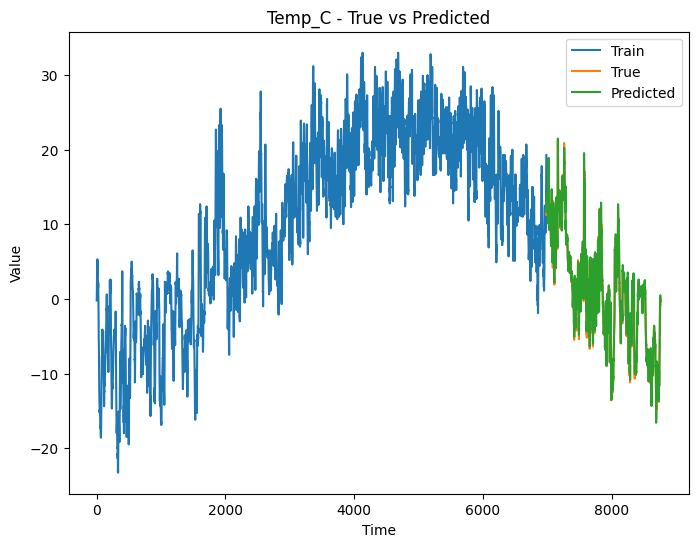

Метрики Temp_C
MSE: 0.6478342247002098
RMSE: 0.8048814973026835
MAE: 0.5641090556420556
SMAPE: 0.06
R2: 0.9876447371901125 



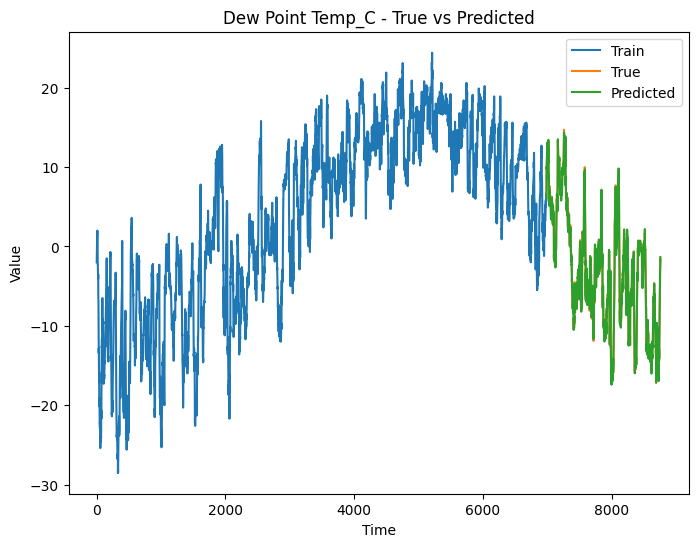

Метрики Dew Point Temp_C
MSE: 0.5368264715415437
RMSE: 0.7326844283465725
MAE: 0.5111518572267792
SMAPE: 0.056
R2: 0.9897024800502638 



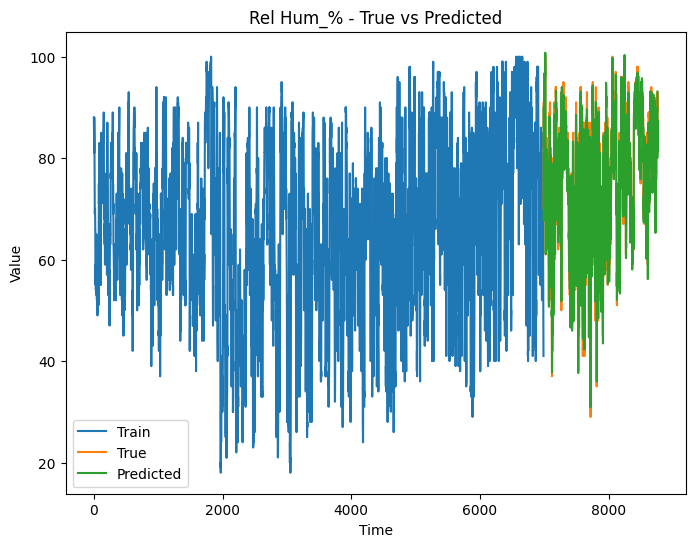

Метрики Rel Hum_%
MSE: 16.325897765027
RMSE: 4.040531866602094
MAE: 2.9172700849594158
SMAPE: 0.01
R2: 0.9096985537671068 



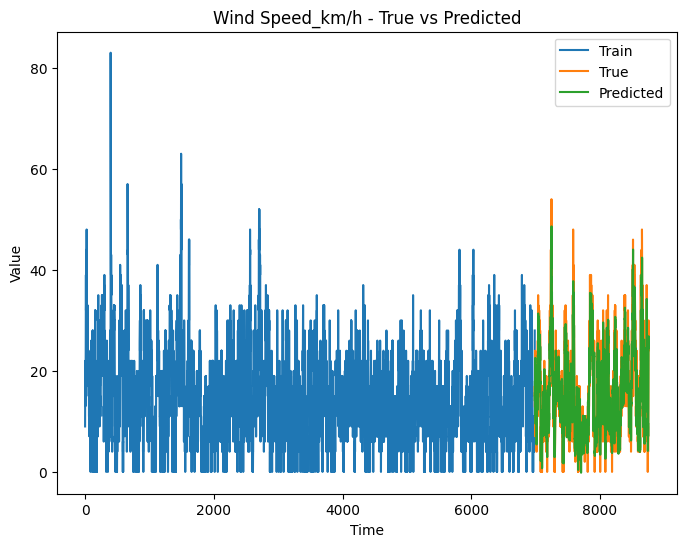

Метрики Wind Speed_km/h
MSE: 17.94646963559549
RMSE: 4.236327375875889
MAE: 3.181901807869091
SMAPE: 0.065
R2: 0.7952328492970049 



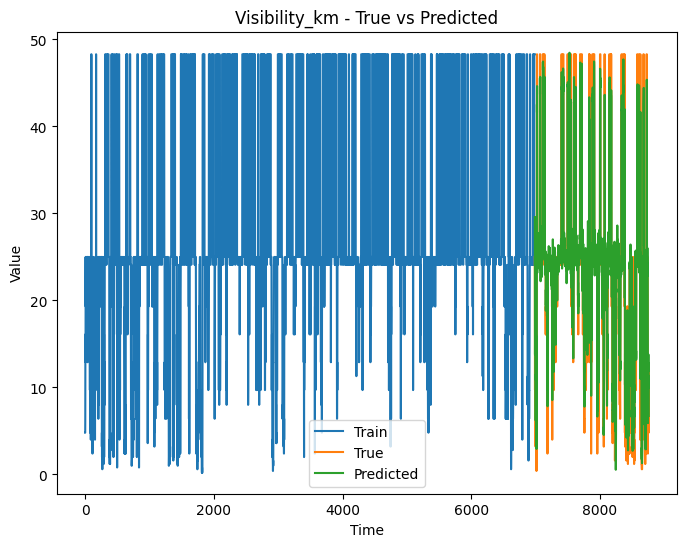

Метрики Visibility_km
MSE: 27.564663536710828
RMSE: 5.250206047071946
MAE: 2.9491980155315605
SMAPE: 0.044
R2: 0.7465788910481174 



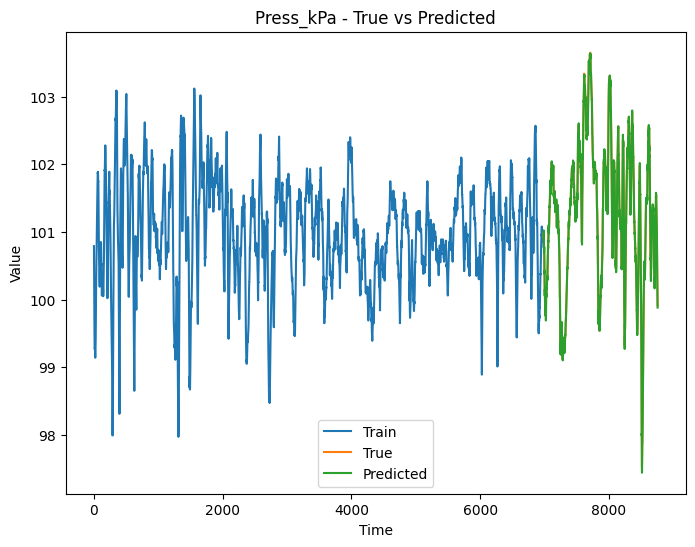

Метрики Press_kPa
MSE: 0.0017393063319574807
RMSE: 0.0417049916911331
MAE: 0.0311134250163533
SMAPE: 0.0
R2: 0.998514387449542 



In [ ]:
plot_and_metrics(data.columns, Y_test, Y_pred, Y_train)

По метрикам:<br>

Адекватное MSE, RMSE, MAE - ниже единицы, что есть хорошо, близко к нулю.<br>
SMAPE тоже показывает себя неплохо (где-то в итоге около нуля, что идеально).<br>
R2 ~= 0.99, почти отлично, очень близко к единице.<br>

#### VARMA

VARMA (Vector AutoRegressive Moving-Average) - это стохастическая модель, используемая в области временных рядов для моделирования взаимосвязей между несколькими временными рядами одновременно. В этой модели предполагается, что каждый из временных рядов влияет на другие.

VARMA - это обобщение модели ARMA (AutoRegressive Moving Average). В модели ARMA каждый временной ряд моделируется на основе его собственных предыдущих значений (авторегрессионный элемент) и ошибок прогнозирования (скользящая средняя).

Однако в модели VARMA каждый временной ряд моделируется не только на основе его собственных предыдущих значений, но и на основе предыдущих значений других временных рядов.

In [ ]:
X = data
train, test = X[:7000], X[7000:]

Подберём оптимальные параметры для обучения при помощи AutoArima.<br>

In [ ]:
pq = []
for name, column in data.items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Temp_C
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23574.958, Time=4.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25488.137, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23974.311, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24474.098, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25486.138, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23510.313, Time=8.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23543.734, Time=2.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23481.742, Time=4.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=23487.177, Time=1.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=22958.011, Time=16.29 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=23471.015, Time=3.34 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=22899.191, Time=19.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=23422.911, Time=2.82 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=22

In [ ]:
pq

[(7, 1, 1), (1, 1, 2), (3, 1, 0), (1, 1, 1), (0, 1, 7), (1, 1, 3)]

Подберем опытным путём наилучший порядок

In [ ]:
df_results_moni = pd.DataFrame(columns=['p', 'q',"RMSE Temp_C", "RMSE Dew Point Temp_C", "RMSE Rel Hum_%", "RMSE Wind Speed_km/h", "RMSE Visibility_km", "RMSE Press_kPa"])

for i in pq:
    if i[0]== 0 and i[2]==0:
        pass
    else:
        model = VARMAX(train, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(test))
        temp_c_rmse = np.sqrt(metrics.mean_squared_error(test['Temp_C'], result['Temp_C']))
        dew_point_temp_c_rmse = np.sqrt(metrics.mean_squared_error(test['Dew Point Temp_C'], result['Dew Point Temp_C']))
        rel_hum_rmse = np.sqrt(metrics.mean_squared_error(test['Rel Hum_%'], result['Rel Hum_%']))
        wind_speed_rmse = np.sqrt(metrics.mean_squared_error(test['Wind Speed_km/h'], result['Wind Speed_km/h']))
        visibility_rmse = np.sqrt(metrics.mean_squared_error(test['Visibility_km'], result['Visibility_km']))
        press_rmse = np.sqrt(metrics.mean_squared_error(test['Press_kPa'], result['Press_kPa']))
        new_row = {'p': i[0], 'q': i[2], 'RMSE Temp_C': temp_c_rmse, 'RMSE Dew Point Temp_C': dew_point_temp_c_rmse, 'RMSE Rel Hum_%': rel_hum_rmse, 'RMSE Wind Speed_km/h': wind_speed_rmse, 'RMSE Visibility_km': visibility_rmse, 'RMSE Press_kPa': press_rmse}
        df_results_moni = pd.concat([df_results_moni, pd.DataFrame([new_row])], ignore_index=True)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/pyt

KeyboardInterrupt: 

In [ ]:
df_results_moni.sort_values(by = ["RMSE Temp_C", "RMSE Dew Point Temp_C", "RMSE Rel Hum_%", "RMSE Wind Speed_km/h", "RMSE Visibility_km", "RMSE Press_kPa"] )

p  q  RMSE Temp_C  RMSE Dew Point Temp_C  RMSE Rel Hum_%  \
3  1  1    12.083076              10.058836       17.096805   
2  3  0    12.111017              10.025451       16.970452   
0  7  1    12.112286              10.020084       16.950175   
4  0  7    12.113747              10.013280       16.933845   
1  1  2    12.395261              10.392242       16.996262   

   RMSE Wind Speed_km/h  RMSE Visibility_km  RMSE Press_kPa  
3              9.414596           11.869131        1.133259  
2              9.423931           11.899282        1.124291  
0              9.423498           11.907045        1.123614  
4              9.420283           11.887873        1.122929  
1              9.477432           11.938022        1.123241

Наилучшие p, q - 1,1

In [ ]:
model = VARMAX(train, order=(1,1)).fit(disp=False)
result = model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Посмотрим на полученный результат

In [ ]:
result

Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  Visibility_km  \
7000  18.132429          3.271235  37.460935        23.297898      45.821802   
7001  17.979134          3.264213  37.765265        21.880618      43.346153   
7002  17.752766          3.282102  38.475599        20.705246      41.269261   
7003  17.476059          3.318114  39.473866        19.735137      39.516178   
7004  17.166427          3.366837  40.668569        18.938324      38.027314   
...         ...               ...        ...              ...            ...   
8779  10.661917          3.857632  65.309302        14.768785      28.790824   
8780  10.661862          3.857582  65.309306        14.768792      28.790813   
8781  10.661807          3.857531  65.309309        14.768799      28.790803   
8782  10.661753          3.857480  65.309312        14.768807      28.790792   
8783  10.661698          3.857429  65.309315        14.768813      28.790782   

       Press_kPa  
7000  100.791919  
7001  100.781261  
7002  100.770536  
7003  100.759941  
7004  100.749622  
...          ...  
8779  100.957039  
8780  100.957038  
8781  100.957038  
8782  100.957037  
8783  100.957037  

[1784 rows x 6 columns]

Считаем метрики и отрисовываем предсказания.

In [ ]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred):
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'SMAPE: {smape_score(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

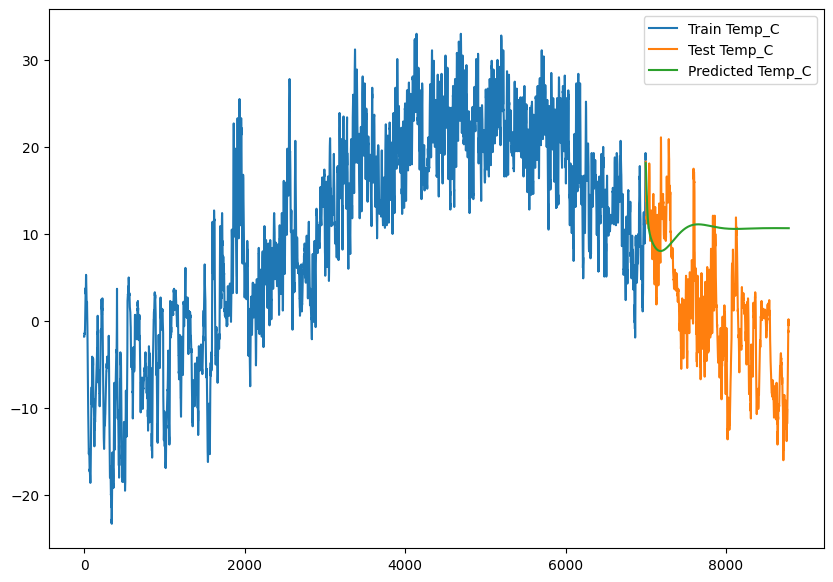

Evaluation metric for Temp_C
MSE: 146.0007190646466
MAE: 10.442823899052977
RMSE: 12.083075728664726
SMAPE: 0.341
R2: -1.7423597774872417



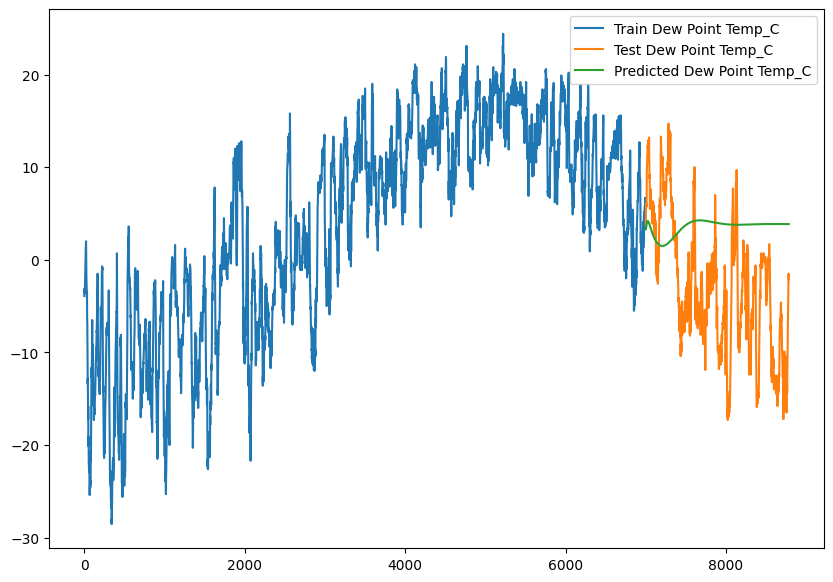

Evaluation metric for Dew Point Temp_C
MSE: 101.18018203301567
MAE: 8.637694651674087
RMSE: 10.058836017801248
SMAPE: 0.419
R2: -0.9368088055523471



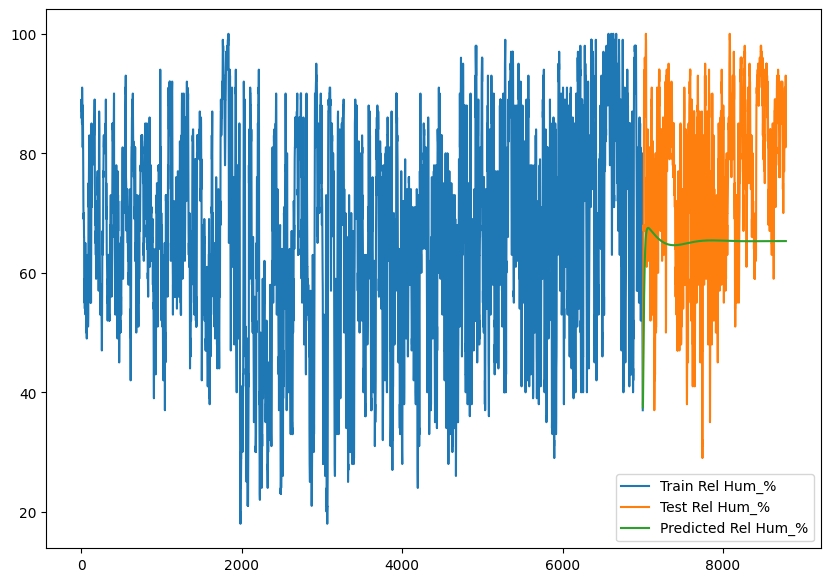

Evaluation metric for Rel Hum_%
MSE: 292.30075415623725
MAE: 14.54355787863834
RMSE: 17.096805378673444
SMAPE: 0.05
R2: -0.6013042402294853



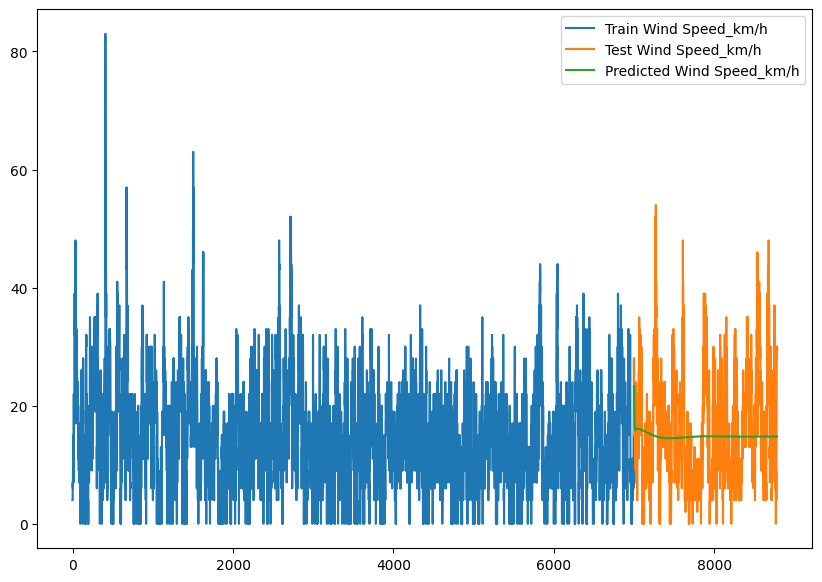

Evaluation metric for Wind Speed_km/h
MSE: 88.63461853778888
MAE: 7.44284307097258
RMSE: 9.414596036888087
SMAPE: 0.126
R2: -0.016308567011407815



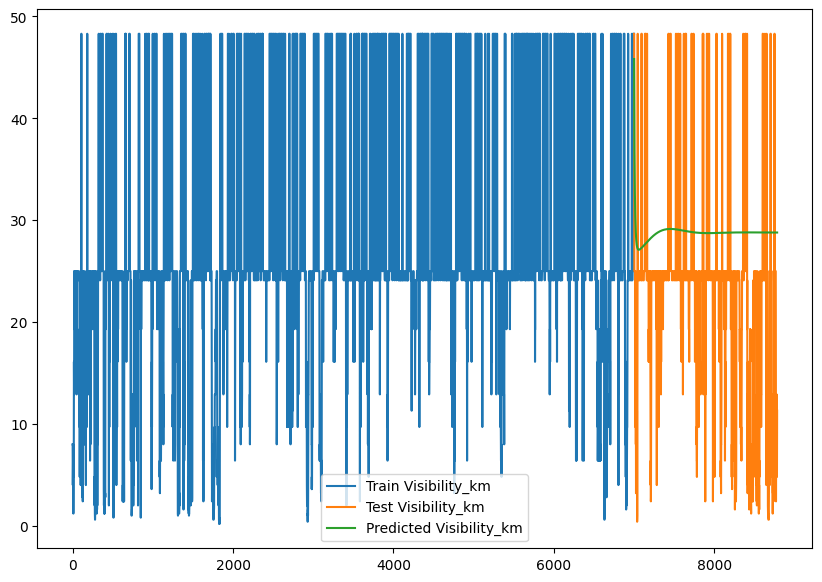

Evaluation metric for Visibility_km
MSE: 140.87626735738655
MAE: 9.097802408174879
RMSE: 11.869130859392635
SMAPE: 0.101
R2: -0.2949597453915136



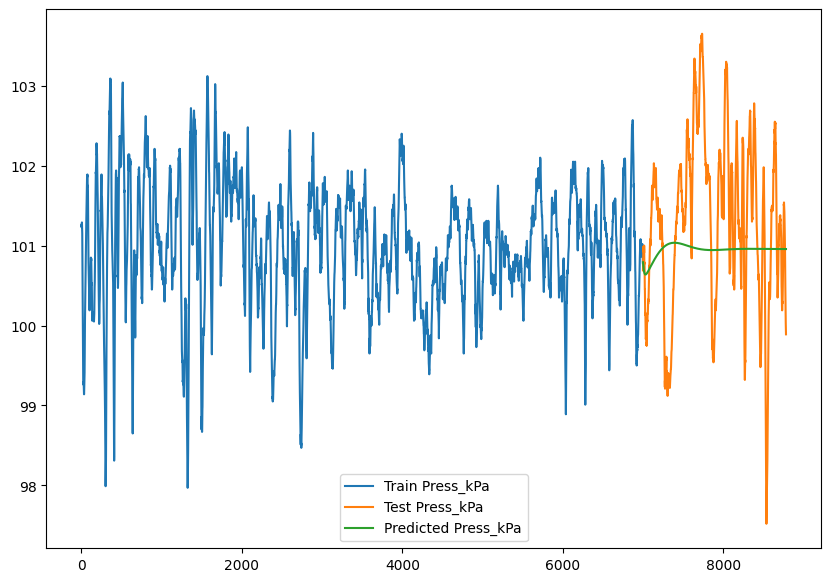

Evaluation metric for Press_kPa
MSE: 1.2842752765522956
MAE: 0.9237503697001833
RMSE: 1.133258697982193
SMAPE: 0.002
R2: -0.10278809137117739



In [ ]:
for i in ["Temp_C", "Dew Point Temp_C", "Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"]:
    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(train[str(i)], label='Train '+str(i))
    plt.plot(range(7000, 8784), test[str(i)], label='Test '+str(i))
    plt.plot(range(7000, 8784), result[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , result[str(i)])

На последней метрике MSE, RMSE - у, MAE показал более хороший по сравнению с другими результат, SMAPE не так идеален, но тоже более менее удовлетворителен по сравнению с другими, R2 - отрицателен, поэтому это плохо.<br>

Метрики для всех таргетов, кроме последней показали объективно кошмарный результат

Как итог - метрики ужасны, и на самом деле они оставляют желать лучшего.

## Нейросети

#### LSTM

LSTM (Long Short-Term Memory) - это тип рекуррентной нейронной сети (RNN), разработанный для работы с последовательными данными, такими как временные ряды, тексты, аудио и другие последовательные данные.

Основная особенность LSTM заключается в способности учитывать зависимости и долгосрочные зависимости в данных, что часто бывает сложно для обычных RNN. Они обладают способностью запоминать информацию на протяжении длительных временных интервалов и избегать проблемы затухания/взрыва градиентов, которая часто встречается у обычных RNN.

Подготовим данные и отмасштабируем их для обучения.

In [ ]:
df_LSTM = pd.DataFrame(data['Date'])
df_LSTM['Temp_C'] = data['Temp_C']
df_LSTM['Dew Point Temp_C'] = data['Dew Point Temp_C']
df_LSTM['Rel Hum_%'] = data['Rel Hum_%']
df_LSTM['Wind Speed_km/h'] = data['Wind Speed_km/h']
df_LSTM['Visibility_km'] = data['Visibility_km']
df_LSTM['Press_kPa'] = data['Press_kPa']
df_LSTM.set_index('Date', inplace=True)

lookback_window = 1

df_LSTM = df_LSTM.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_LSTM[i - lookback_window:i])
    y.append(df_LSTM[i])
x = np.array(x)
y = np.array(y)

In [ ]:
x_train = x[0:7000]
y_train = y[0:7000]
x_test = x[7000:]
y_test = y[7000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 6)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 6)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 6)).reshape(x_test.shape)

Определим саму модель и обучим её.

In [ ]:
i = Input(shape=(lookback_window, 6))
m = LSTM(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(6, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 90)                34920     
                                                                 
 dense_1 (Dense)             (None, 6)                 546       
                                                                 
Total params: 35466 (138.54 KB)
Trainable params: 35466 (138.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

Сделаем предсказания и вернём значения к исходному масштабу, посчитаем метрики и отрисуем прогнозы.

In [ ]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 6)).reshape(y_pred_scaled.shape)

56/56 [==============================] - 0s 6ms/step


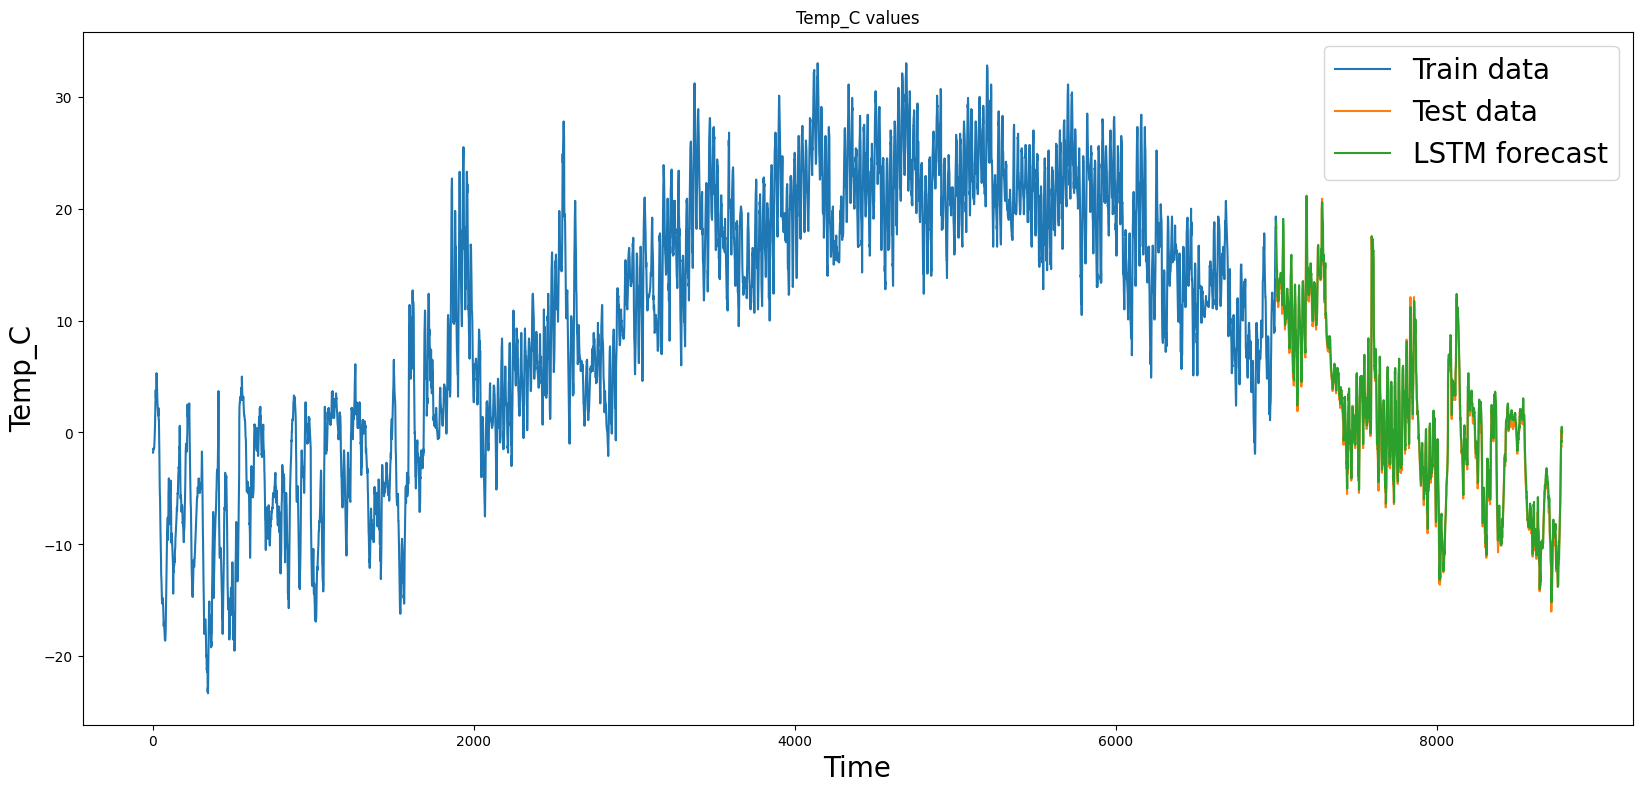

LSTM Metrics Temp_C:
RMSE: 1.0125852329072271
MSE: 1.0253288539017835
SMAPE: 0.078
MAE: 0.7657555324444887
R^2: 0.9806916080768384


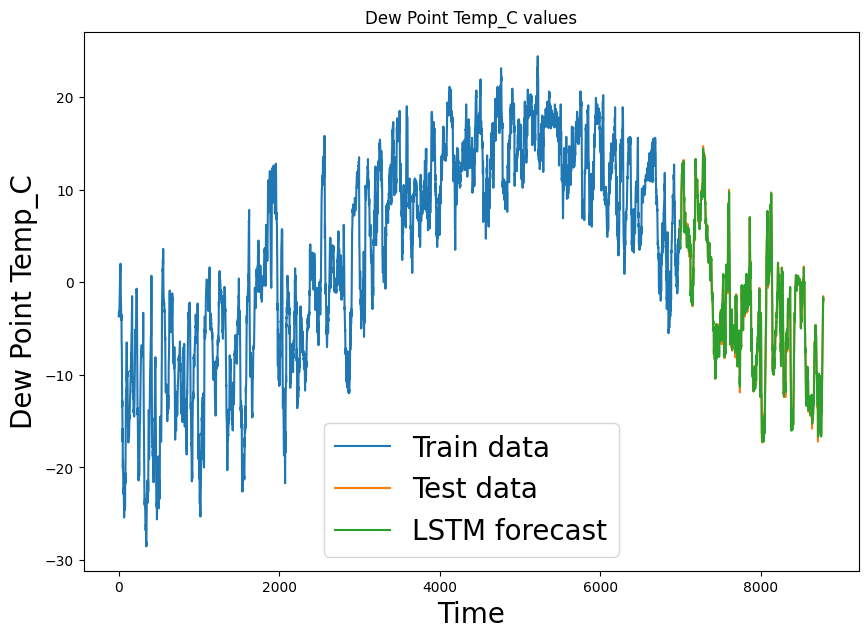

LSTM Metrics Dew Point Temp_C:
RMSE: 0.7774074940558495
MSE: 0.6043624118141957
SMAPE: 0.058
MAE: 0.5521096231956941
R^2: 0.9884319858355656


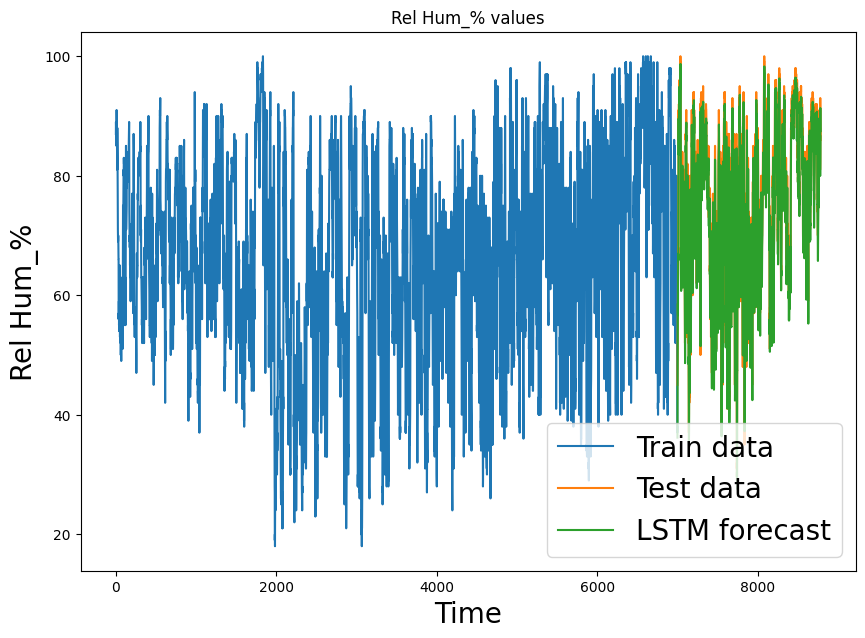

LSTM Metrics Rel Hum_%:
RMSE: 4.540076127332272
MSE: 20.612291241972397
SMAPE: 0.012
MAE: 3.4195485214002335
R^2: 0.886651572770438


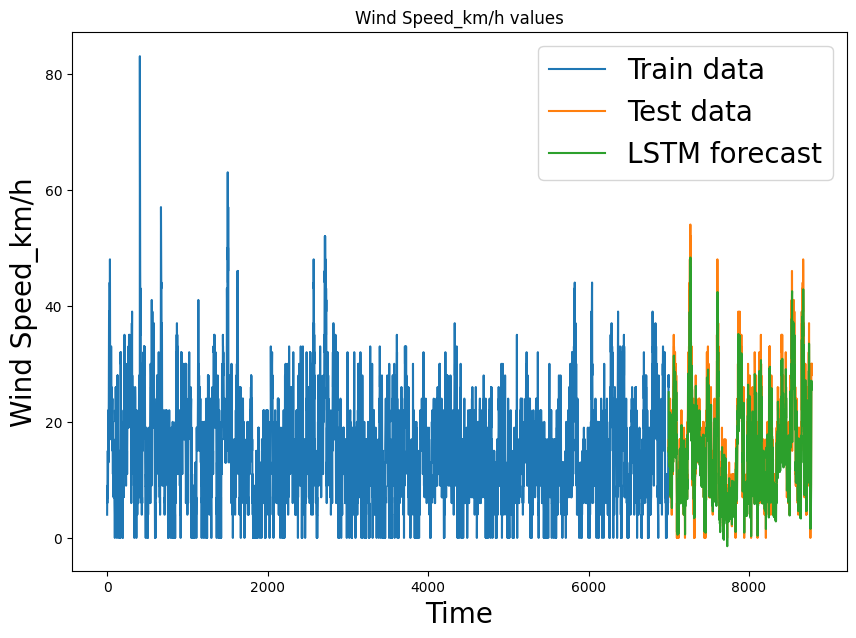

LSTM Metrics Wind Speed_km/h:
RMSE: 4.5714832236170935
MSE: 20.898458863812536
SMAPE: 0.071
MAE: 3.3886674352144834
R^2: 0.7602833569116942


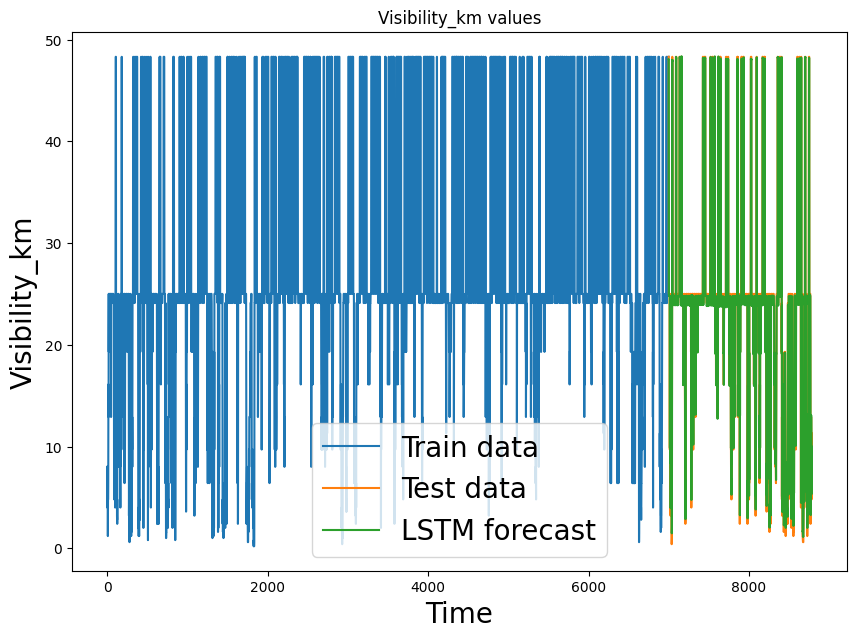

LSTM Metrics Visibility_km:
RMSE: 5.498135875859718
MSE: 30.229498109415708
SMAPE: 0.034
MAE: 2.1545979275839824
R^2: 0.7213694003541016


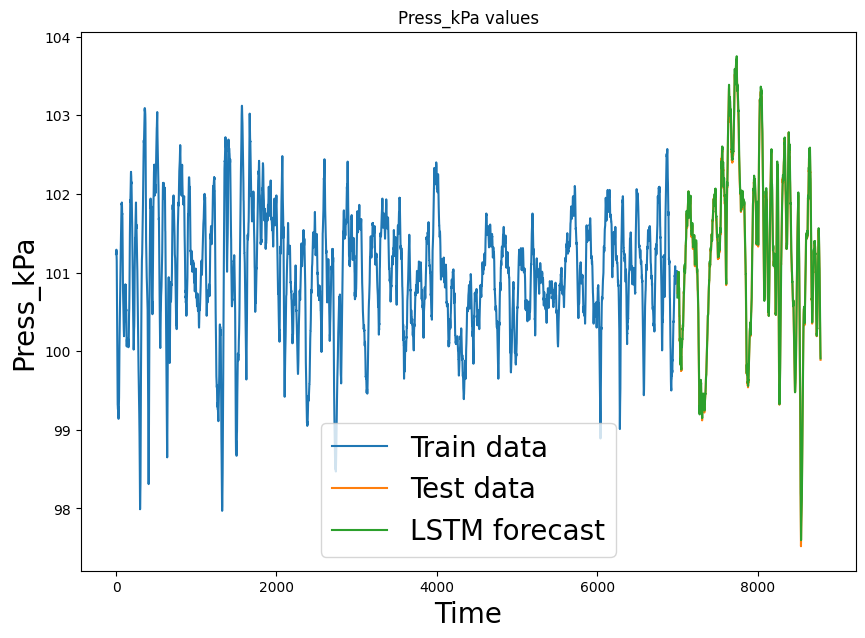

LSTM Metrics Press_kPa:
RMSE: 0.0703510349664888
MSE: 0.0049492681208561295
SMAPE: 0.0
MAE: 0.05383364726102417
R^2: 0.9957517610902856


In [ ]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ["Temp_C", "Dew Point Temp_C", "Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"]

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='LSTM forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"LSTM Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

Метрики примерно одинаковые, но они просто отличные.<br>
RMSE, MSE, MAE < 1 и очень близок к нулю, что почти идеально.<br>
SMAPE < 1 и где-то даже очень близок к нулю, что почти идеально.<br>
R2 с небольшими погрешностями можно назвать идеальным.<br>

#### GRU

GRU (Gated Recurrent Units) - это один из типов рекуррентных нейронных сетей, предложенный в 2014 году. Он был создан как более простая альтернатива LSTM (Long Short-Term Memory), другому типу рекуррентных сетей.

Главной отличительной особенностью GRU является меньшее число элементов управления или "ворот". У LSTM есть три ворота: входное, забывающее и выходное, а у GRU - всего два: обновляющее и сбрасывающее.

Обновляющее ворото в модели GRU определяет, какую часть предыдущего состояния следует сохранить, а сбрасывающее ворото контролирует, как много прошлого состояния использовать для вычисления текущего состояния.

По сути, GRU пытается решить проблему памяти в обычных рекуррентных сетях, взяв наиболее эффективные элементы LSTM, но упростив их. И, хотя GRU модели обычно требуют меньше объема вычислений по сравнению с LSTM, их эффективность сильно зависит от конкретной задачи.

Определим данные и масштабируем их.

In [ ]:
df_GRU = pd.DataFrame(data['Date'])
df_GRU['Temp_C'] = data['Temp_C']
df_GRU['Dew Point Temp_C'] = data['Dew Point Temp_C']
df_GRU['Rel Hum_%'] = data['Rel Hum_%']
df_GRU['Wind Speed_km/h'] = data['Wind Speed_km/h']
df_GRU['Visibility_km'] = data['Visibility_km']
df_GRU['Press_kPa'] = data['Press_kPa']
df_GRU.set_index('Date', inplace=True)

lookback_window = 1

df_GRU = df_GRU.values
scaler = MinMaxScaler()

x, y = [], []
for i in range(lookback_window, len(df_LSTM)):
    x.append(df_GRU[i - lookback_window:i])
    y.append(df_GRU[i])
x = np.array(x)
y = np.array(y)

In [ ]:
x_train = x[0:7000]
y_train = y[0:7000]
x_test = x[7000:]
y_test = y[7000:]

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 6)).reshape(x_train.shape)
y_train_scaled = scaler.transform(y_train.reshape(-1, 6)).reshape(y_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, 6)).reshape(x_test.shape)

Определим саму модель и обучим её.

In [ ]:
i = Input(shape=(lookback_window, 6))
m = GRU(units=90, activation='tanh', return_sequences=False)(i)
m = Dense(6, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 gru (GRU)                   (None, 90)                26460     
                                                                 
 dense_2 (Dense)             (None, 6)                 546       
                                                                 
Total params: 27006 (105.49 KB)
Trainable params: 27006 (105.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train_scaled, y_train_scaled, epochs=20, verbose=0)

Сделаем предсказания и вернём значения к исходному масштабу, посчитаем метрики и отрисуем прогнозы.

In [ ]:
y_pred_scaled = model.predict(x_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 6)).reshape(y_pred_scaled.shape)

56/56 [==============================] - 2s 10ms/step


Сделаем предсказания для модели на тестовой выборке.

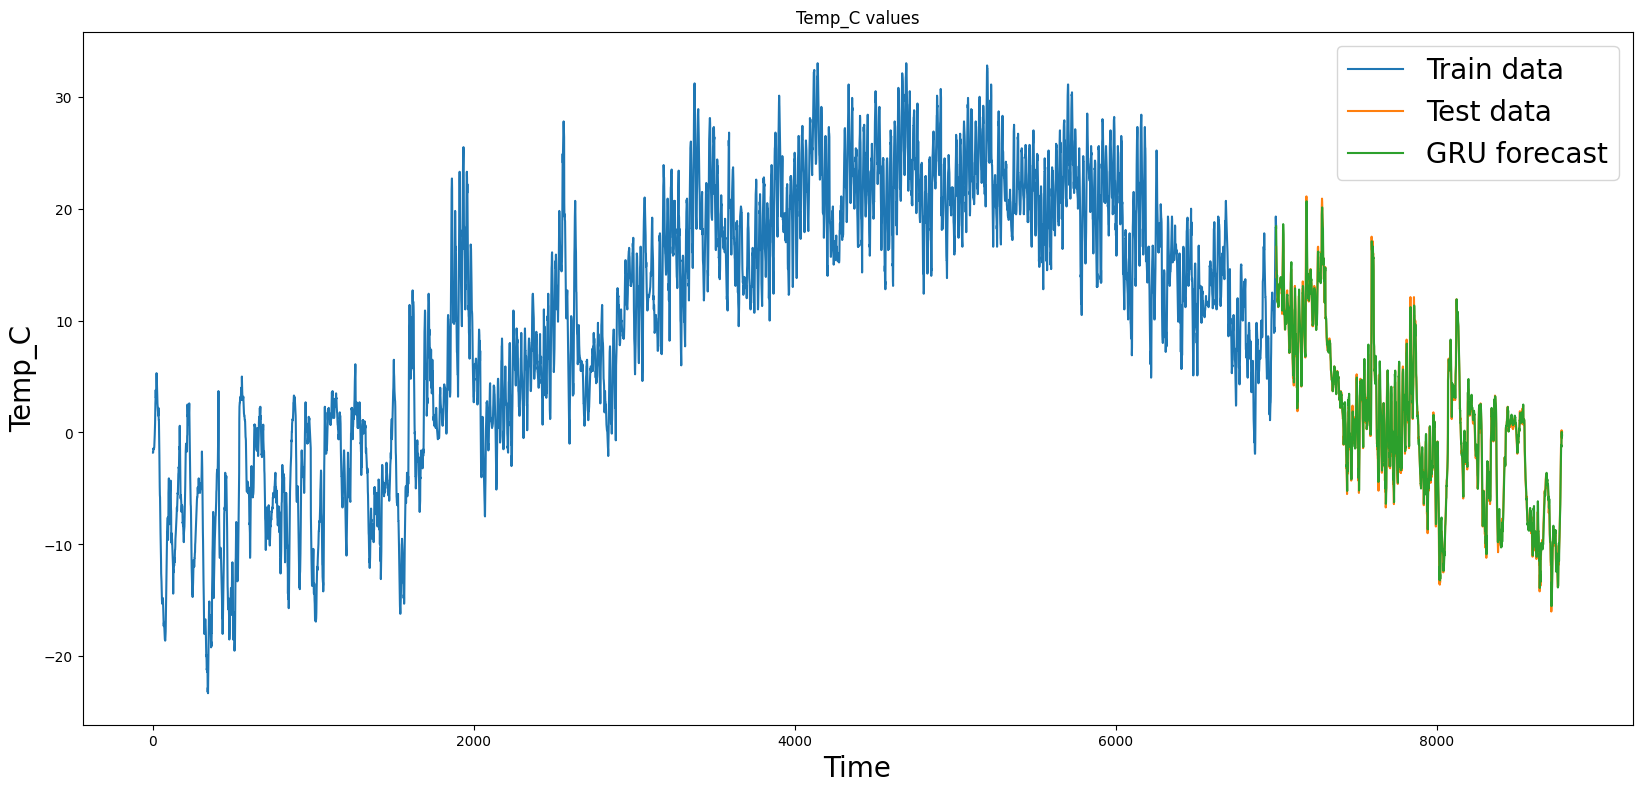

GRU Metrics Temp_C:
RMSE: 0.9081340878812576
MSE: 0.8247075215719237
SMAPE: 0.067
MAE: 0.6403631900485754
R^2: 0.9844695914019257


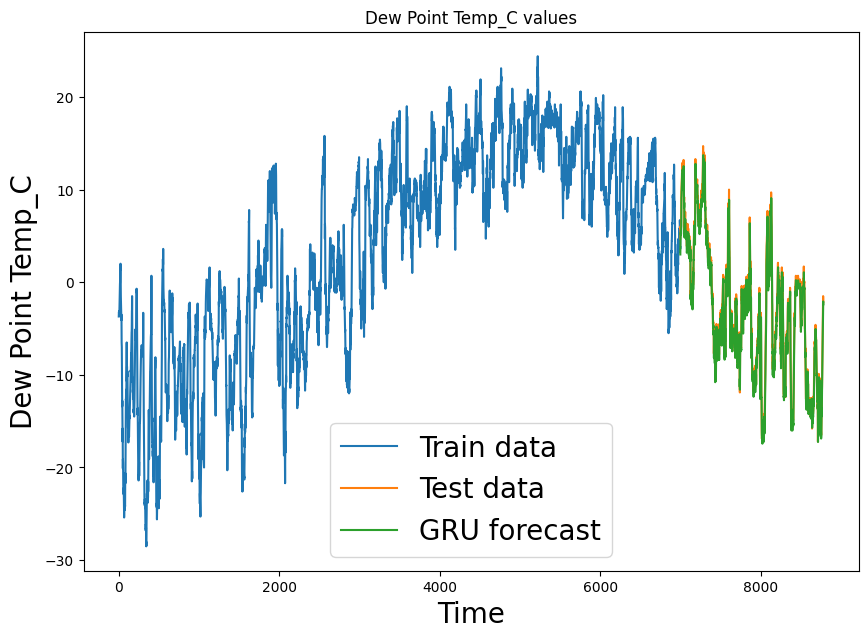

GRU Metrics Dew Point Temp_C:
RMSE: 0.8930498242421178
MSE: 0.7975379885788774
SMAPE: 0.072
MAE: 0.6929636718975866
R^2: 0.9847344398523061


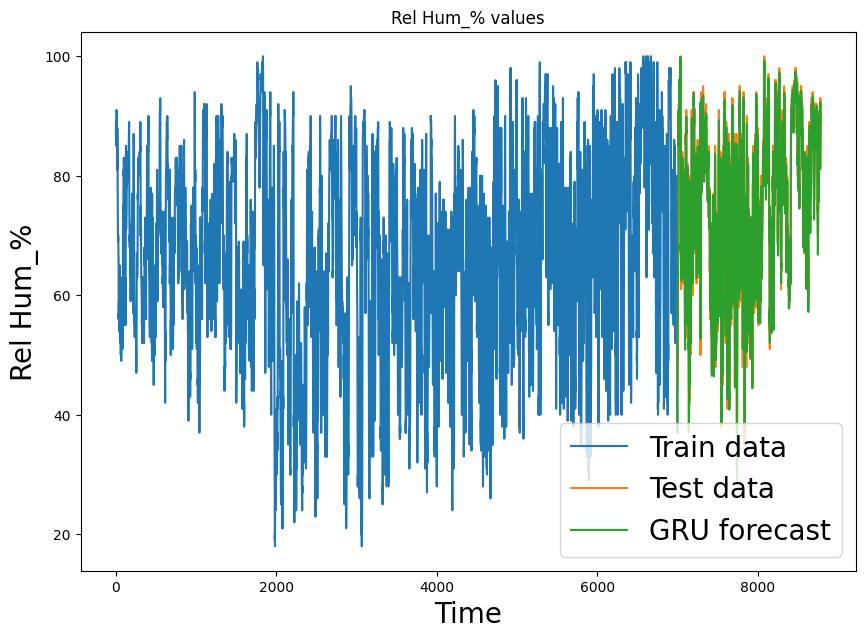

GRU Metrics Rel Hum_%:
RMSE: 4.235415818891314
MSE: 17.938747158914776
SMAPE: 0.011
MAE: 3.0357707093688657
R^2: 0.9013535781606201


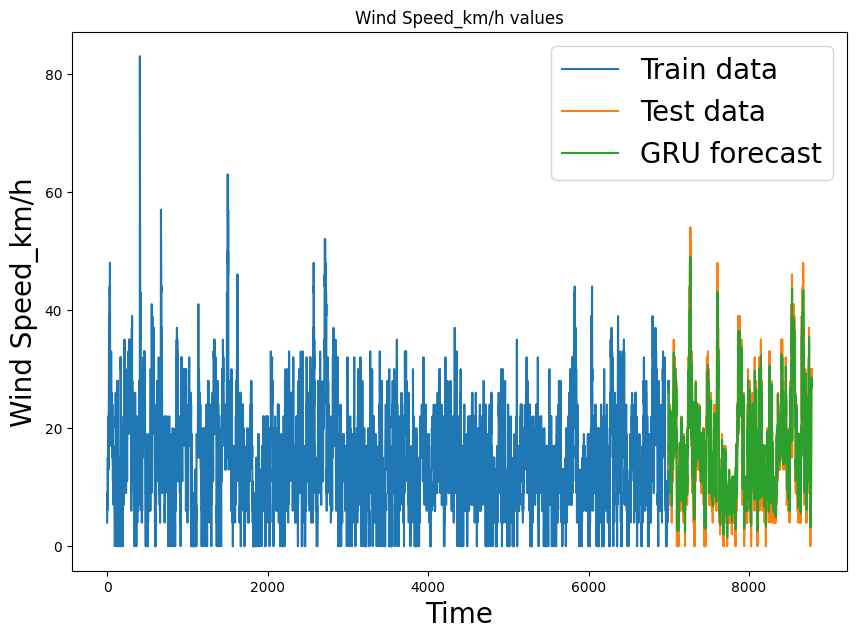

GRU Metrics Wind Speed_km/h:
RMSE: 4.370762849219203
MSE: 19.103567884114767
SMAPE: 0.067
MAE: 3.3146540885953106
R^2: 0.7808717286747274


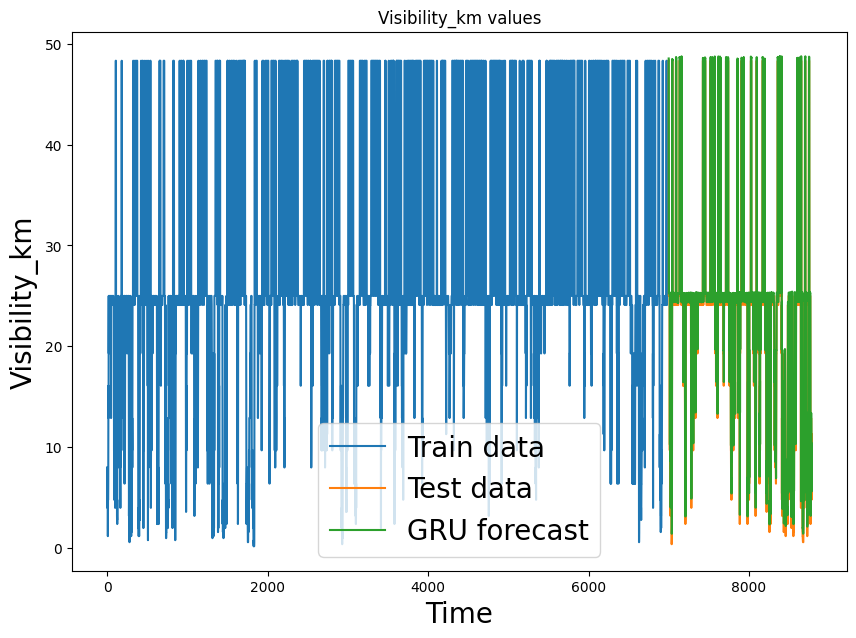

GRU Metrics Visibility_km:
RMSE: 5.514717709206085
MSE: 30.41211141223121
SMAPE: 0.035
MAE: 2.2356429769828354
R^2: 0.7196862214312285


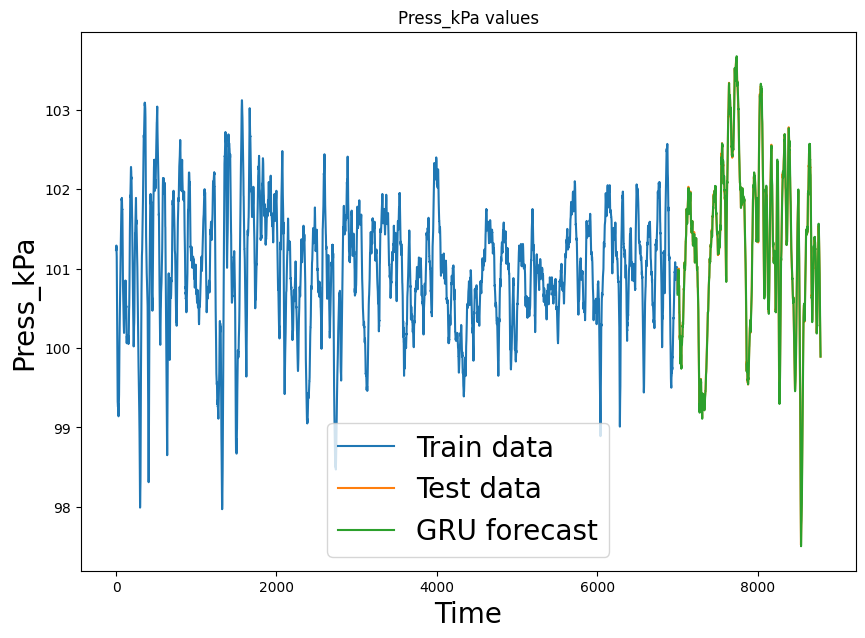

GRU Metrics Press_kPa:
RMSE: 0.06439615163983606
MSE: 0.004146864346020761
SMAPE: 0.0
MAE: 0.049302818995811175
R^2: 0.9964405099829133


In [ ]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ["Temp_C", "Dew Point Temp_C", "Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"]

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='GRU forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"GRU Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

Метрики примерно одинаковые, но они просто отличные.<br>
RMSE, MSE, MAE < 1 и очень близок к нулю, что почти идеально.<br>
SMAPE < 1 и где-то даже очень близок к нулю, что почти идеально.<br>
R2 с небольшими погрешностями можно назвать идеальным.<br>

В целом показала такой же результат, как и LSTM.

#### TCN

TCN (Temporal Convolutional Network) - это тип нейронной сети, предназначенный для работы с последовательными данных, такими как временные ряды. Эта архитектура основана на использовании сверточных слоев для извлечения признаков из последовательных данных.

Подготовим данные.

In [ ]:
df_tcn = pd.DataFrame(data['Date'])
df_tcn['Temp_C'] = data['Temp_C']
df_tcn['Dew Point Temp_C'] = data['Dew Point Temp_C']
df_tcn['Rel Hum_%'] = data['Rel Hum_%']
df_tcn['Wind Speed_km/h'] = data['Wind Speed_km/h']
df_tcn['Visibility_km'] = data['Visibility_km']
df_tcn['Press_kPa'] = data['Press_kPa']
df_tcn.set_index('Date', inplace=True)

lookback_window = 20

df_tcn = df_tcn.values

x, y = [], []
for i in range(lookback_window, len(df_tcn)):
    x.append(df_tcn[i - lookback_window:i])
    y.append(df_tcn[i])
x = np.array(x)
y = np.array(y)

Делим данные на обучающую и тестовые выборки

In [ ]:
x_train = x[0:7000]
y_train = y[0:7000]
x_test = x[7000:]
y_test = y[7000:]

Определим модель и обучим её.

In [ ]:
i = Input(shape=(lookback_window, 6))
m = TCN()(i)
m = Dense(6, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()
model.compile('adam', 'mae')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 tcn (TCN)                   (None, 64)                137536    
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 137926 (538.77 KB)
Trainable params: 137926 (538.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=100, verbose=0)

Делаем предикты

In [ ]:
y_pred = model.predict(x_test)

56/56 [==============================] - 1s 12ms/step


Отрисуем предсказания с истинными метками, покажем на графике и посчитаем метрики.

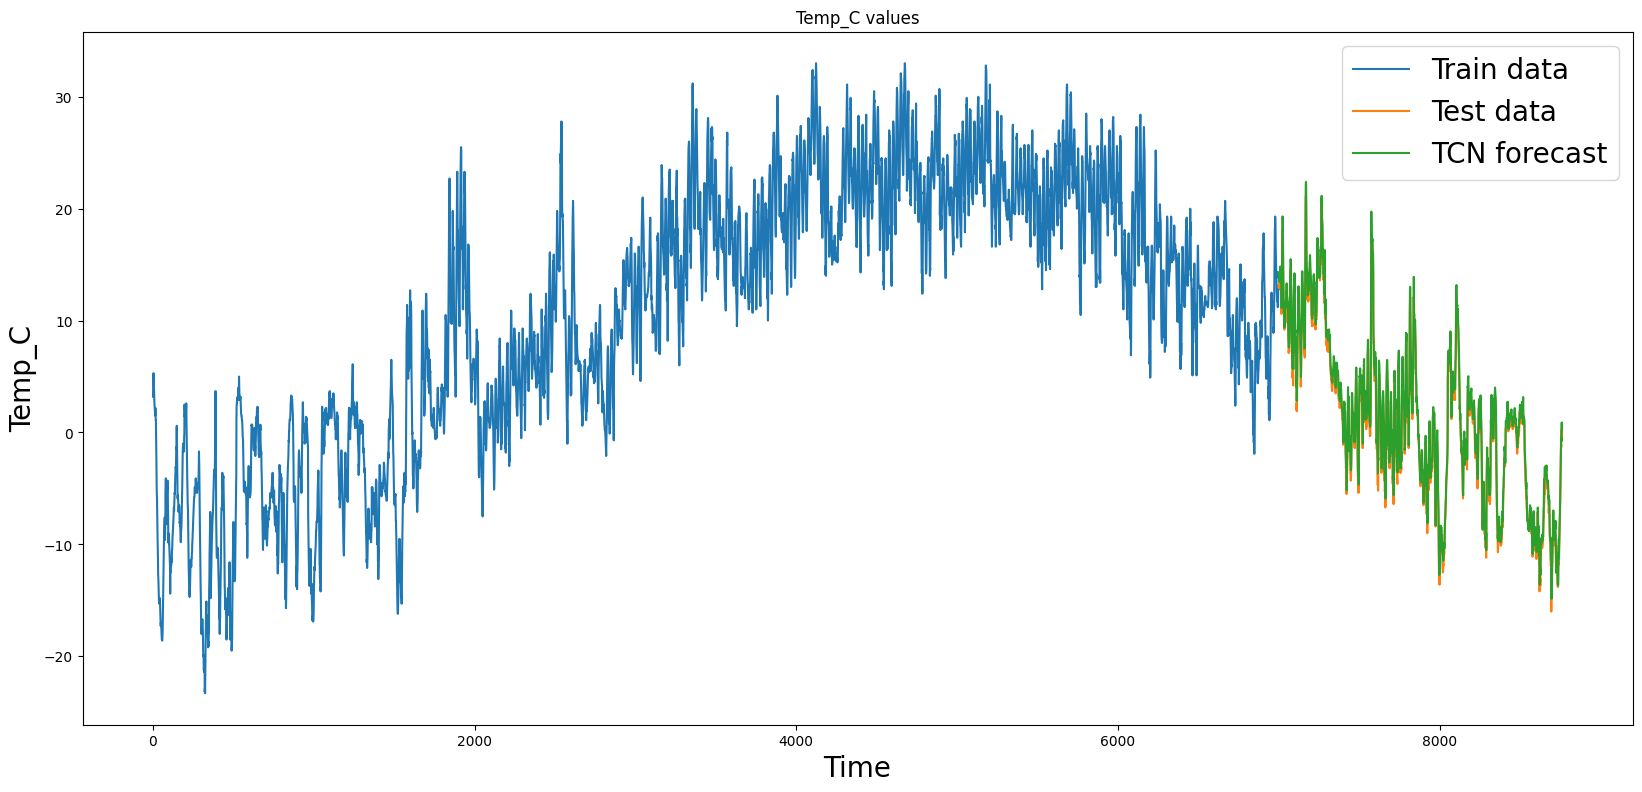

TCN Metrics Temp_C:
RMSE: 1.0475859037245914
MSE: 1.097436225682469
SMAPE: 0.081
MAE: 0.8377660435689889
R^2: 0.9789291369773268


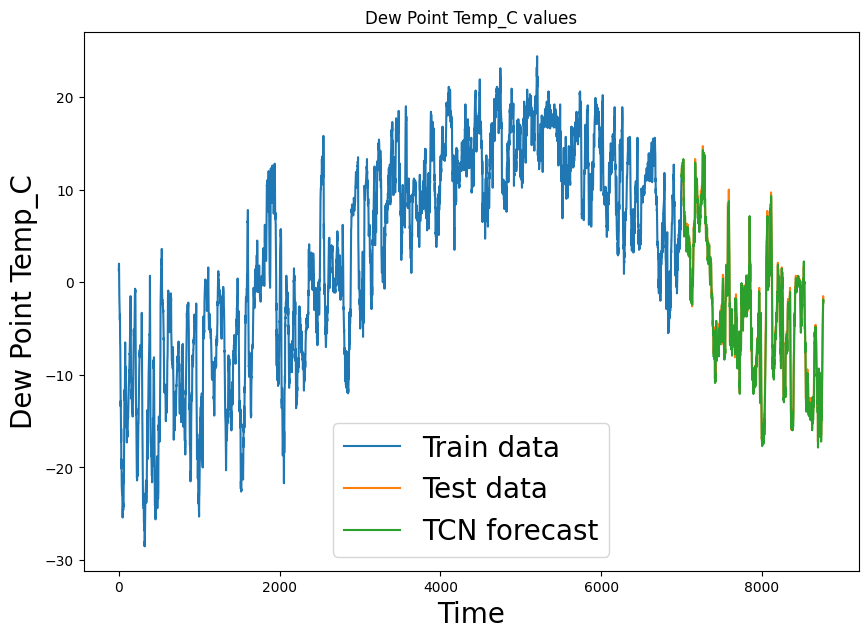

TCN Metrics Dew Point Temp_C:
RMSE: 0.8099297218389814
MSE: 0.6559861543181698
SMAPE: 0.061
MAE: 0.6034034615616967
R^2: 0.9872823222307414


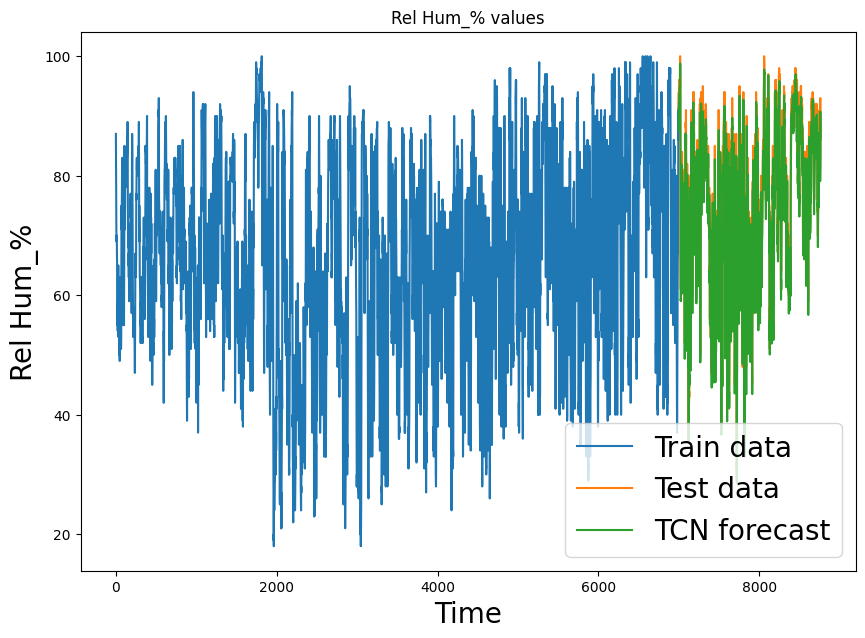

TCN Metrics Rel Hum_%:
RMSE: 4.400861611432158
MSE: 19.367582922977252
SMAPE: 0.012
MAE: 3.3024598541173265
R^2: 0.8929064280379597


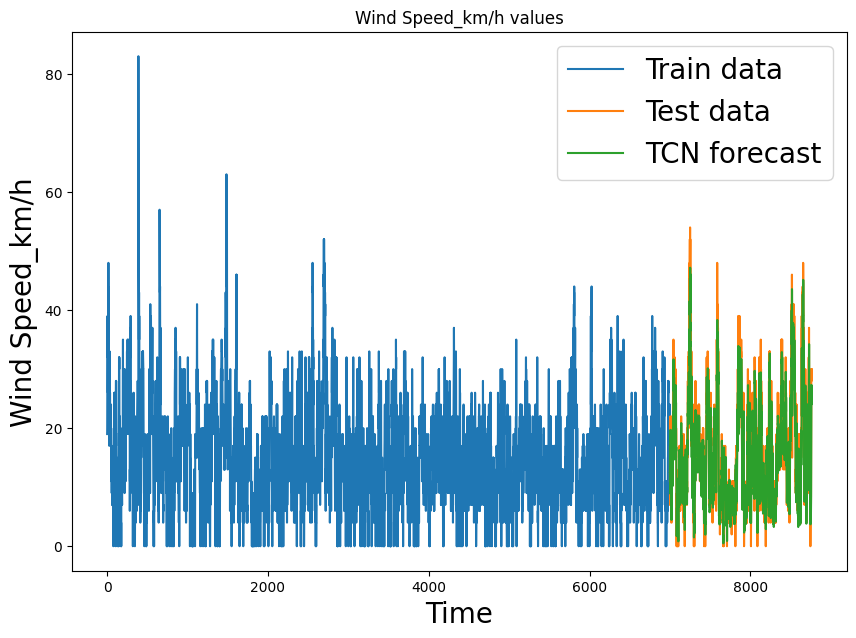

TCN Metrics Wind Speed_km/h:
RMSE: 4.291980043768017
MSE: 18.421092696102914
SMAPE: 0.066
MAE: 3.1966393022648063
R^2: 0.790647072841794


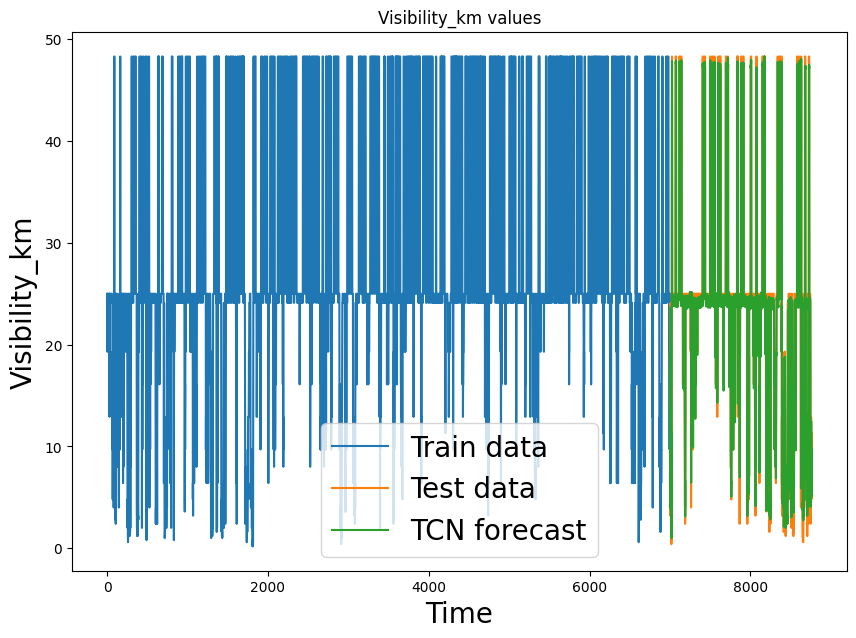

TCN Metrics Visibility_km:
RMSE: 5.435264608965246
MSE: 29.542101369470135
SMAPE: 0.036
MAE: 2.267208196482961
R^2: 0.7290430759550413


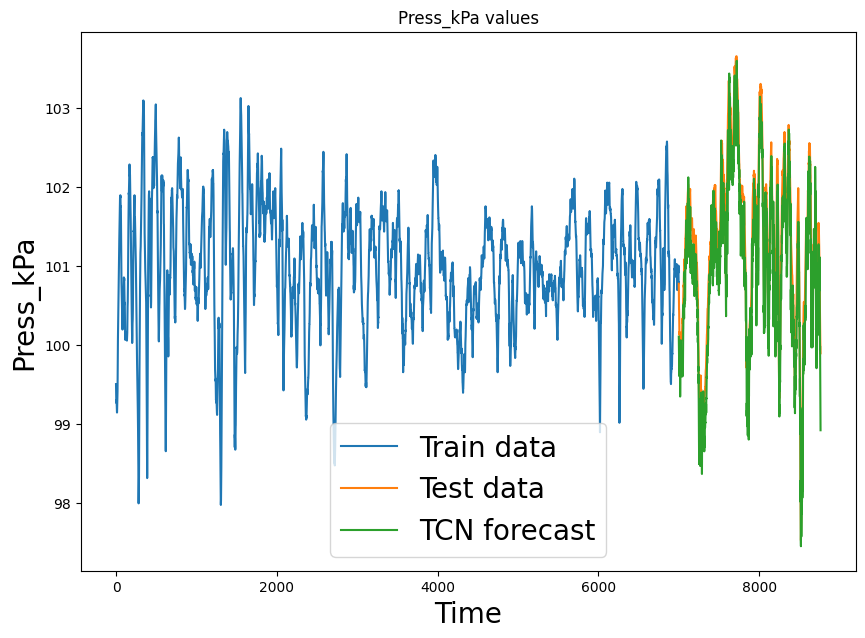

TCN Metrics Press_kPa:
RMSE: 0.43957662036046385
MSE: 0.19322760516752735
SMAPE: 0.001
MAE: 0.3873841740268698
R^2: 0.835653015733915


In [ ]:
fig = plt.figure(figsize=(20, 9))
dur = len(y_pred)
size = int(len(x_train))

columns = ["Temp_C", "Dew Point Temp_C", "Rel Hum_%", "Wind Speed_km/h", "Visibility_km", "Press_kPa"]

for k in range(len(columns)):
    y_test_col = y_test[:, k]
    y_prew_col = y_pred[:, k]

    plt.plot([i for i in range(0, size)], y_train[:, k], label='Train data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_test_col, label='Test data')
    plt.plot([i for i in range(size - 1, size - 1 + dur)], y_prew_col, label='TCN forecast')
    plt.legend(fontsize="20")
    plt.title(f'{columns[k]} values')
    plt.ylabel(f'{columns[k]}', fontsize="20")
    plt.xlabel('Time', fontsize="20")
    plt.show()

    def smape_score(y_true, y_pred):
        return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

    print(f"TCN Metrics {columns[k]}:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_col, y_prew_col)))
    print("MSE:", mean_squared_error(y_test_col, y_prew_col))
    print("SMAPE:", smape_score(y_test_col, y_prew_col))
    print("MAE:", mean_absolute_error(y_test_col, y_prew_col))
    print("R^2:", r2_score(y_test_col, y_prew_col))

RMSE, MSE, MAE < 1, где-то в районе 1 - почти отличный результат.<br>
SMAPE ниже единицы и опять очень близок к нулю, а где-то и вовсе ноль что очень хорошо.<br>
R2 > 0.9, близок к единице, хороший результат.<br>

По результату показала себя чуть хуже, чем LSTM и GRU, но при этом не нужно было масштабировать исходные данные.

## Итог

Среди классических моделей лучше себя показала VAR. Она очень быстро подбирала оптимальные параметры для обучения и очень быстро обучалась, к тому же прогнозы были качественны, как в итоге и сама модель.<br>

Не до конца понятно, почему VARMAX показал плохое качество, но возможно дело было в подборе параметров (параметры из VAR можно было бы интерпретировать на VARMA, но обучение бы длилось очень долго и не факт, что оно было дало хоть какие-то положительные результаты).

Если выделять среди нейронок, то выбор складывается больше в пользу LSTM/GRU за счёт простоты настройки и обучения модели. TCN также хороша тем, что показала очень хороший результат на данных, которые не были отмасштабированы, что является очень хорошим показателем.

Ну и в итоге: нейросеть показала себя лучше классических алгоритмов, за счёт того, что в них не нужно особым образом подготавливать данные, дифференцировать ряды, чтобы сделать их стационарными (хоть и в данной задаче это не потребовалось), поскольку и без этого они выдают отличное качество и при этом предсказанные данные не искажаются (так как никакого дифференцирования для них нету).